In [2]:
import numpy as np
import tensorflow as tf
from random import shuffle, seed, random
from tqdm import tqdm
import cv2
from os import makedirs, listdir, path

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from shutil import copyfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

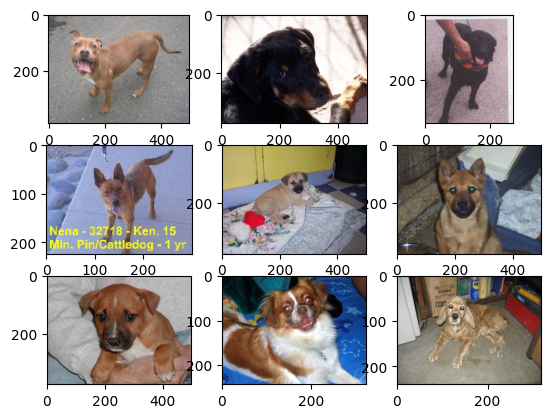

In [29]:
folder = "train/"
subdirs = ["dogs/", "cats/"]
image_files = []

for filename in listdir(folder):
  if filename.startswith("dog"):
    image_files.append(path.join(folder, filename))

image_files = sorted(image_files)

for i in range(9):
  plt.subplot(3, 3, i+1)
  if i < len(image_files):
    image = imread(image_files[i])
    plt.imshow(image)

plt.show()

In [30]:
dataset_home = "dataset_dogs_vs_cats/"
subdirs = ['train/', 'test/']

for subdir in subdirs:
  labeldirs = ['dogs/', 'cats/']

  for labeldir in labeldirs:
    newdir = f"{dataset_home}{subdir}{labeldir}"
    makedirs(newdir, exist_ok=True)

seed(1)

val_ratio = 0.25

src_directory = "train/"

for file in listdir(src_directory):
  src = f"{src_directory}{file}"
  dst_dir = src_directory
  if random() < val_ratio:
    dst_dir = "test/"
  if file.startswith("cat"):
    dst = f"{dataset_home}{dst_dir}cats/{file}"
    copyfile(src, dst)
  elif file.startswith("dog"):
    dst = f"{dataset_home}{dst_dir}dogs/{file}"
    copyfile(src, dst)

In [63]:
def define_model():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))

  for layer in model.layers:
    layer.trainable = False

  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(class1)

  model = Model(inputs=model.inputs, outputs=output)

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

def run_test_harness():
  model = define_model()

  datagen = ImageDataGenerator(featurewise_center=True)

  datagen.mean = [123.68, 116.779, 103.939]

  train_it = datagen.flow_from_directory(
    'dataset_dogs_vs_cats/', 
    class_mode='binary', 
    batch_size=128, 
    target_size=(224, 224)
  )

  model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=1)

  model.save('final_model.keras')

run_test_harness()

Found 10028 images belonging to 2 classes.


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


c:\Users\Adrian Danao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1266']. Received: the structure of inputs=*
  warnings.warn(


14/79 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.6197 - loss: 22.1982

KeyboardInterrupt: 

In [50]:
dataset_home = "finalize_dogs_vs_cats/"
labeldirs = ['dogs/', 'cats/']

for labeldir in labeldirs:
  newdir = path.join(dataset_home, labeldir)
  makedirs(newdir, exist_ok=True)

src_directory = "dataset_dogs_vs_cats/train/"

for labeldir in labeldirs:
  src_subdir = path.join(src_directory, labeldir)
  for file in listdir(src_subdir):
    src = path.join(src_subdir, file)

    if path.isfile(src):
      dst = path.join(dataset_home, labeldir, file)
      copyfile(src, dst)

In [65]:
def load_image(filename):
  img = load_img(filename, target_size=(224, 224))

  img = img_to_array(img)

  img = img.reshape(1, 224, 224, 3)

  img = img.astype('float32')
  img = img - [123.68, 116.779, 103.939]
  return img

def run_example():
  img = load_image("cat.jpg")

  model = load_model('final_model.h5')

  result = model.predict(img)
  print(result[0])

run_example()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[0.74912584]
